# Importing libraries

In [75]:
### Mount to drive ###
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

### Importing libraries ###
import re
import os
# import spacy
import string
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

### Tensorflow dependencies ###
import tensorflow as tf # tensorflow 2.3.1

from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# data file names
fake_path = "/content/drive/My Drive/Fake.csv"
true_path = "/content/drive/My Drive/True.csv"

Mounted at /content/drive


# I. Loading and exploring data 

In [76]:
# Sample data with each class taking 10000 instances
df_fake = pd.read_csv(fake_path, header=0).sample(n=10000, random_state=np.random.randint(0,40000))
df_true = pd.read_csv(true_path, header=0).sample(n=10000, random_state=np.random.randint(0,40000))

In [77]:
# Concatenate the two data frames 
df_fake['label'] = 0
df_true['label'] = 1

df = pd.concat([df_fake, df_true])
df.index = list(range(len(df.index))) # re-index the dataframe
df # print out the data frame

,title,text,subject,date,label
0,Trump Delegate Kicked Out Of RNC After Hoping...,"Another day, another example of right-wing rac...",News,"July 21, 2016",0
1,Malia Obama Is Getting Political And Standing...,Less than a week after her father left office ...,News,"January 27, 2017",0
2,MAXINE WATERS: ‘These people trying to ‘discre...,MAXINE GOT A MAKEOVER and is hopping mad about...,left-news,"Jul 22, 2017",0
3,DINESH D’SOUZA BRILLIANTLY Schools Hollywood R...,If you haven t seen Dinesh D Souza s HILLARY ...,left-news,"Jul 28, 2016",0
4,"BREAKING: WOMEN, MEN ARRESTED After MAJOR BRAW...",The moral decay of our nation continues full s...,left-news,"May 9, 2017",0
...,...,...,...,...,...
19995,Australian PM says business as usual despite c...,SYDNEY (Reuters) - Australian Prime Minister M...,worldnews,"October 27, 2017",1
19996,U.S. Interior Dept. watchdog launches probe in...,WASHINGTON (Reuters) - The Interior Department...,politicsNews,"October 2, 2017",1
19997,China says no intention of using currency deva...,BEIJING (Reuters) - China said on Friday it ha...,politicsNews,"February 24, 2017",1
19998,Central American presidents congratulate Trump,SAN JOSE (Reuters) - The presidents of three C...,politicsNews,"November 9, 2016",1


# II. Exploratory data analysis and cleaning

In [78]:
# Dropping duplicates and re-indexing
original_row_count = len(df.index)
df = df.drop_duplicates()
df = df.reset_index(drop=True)

new_row_count = len(df.index)
print(f'[INFO] {original_row_count - new_row_count} duplicate rows dropped ...')

[INFO] 54 duplicate rows dropped ...


In [79]:
format_ = "%B %d, %Y" # E.g : April 04, 2020
num_invalids = 0

df['date'] = df['date'].apply(lambda x : x.strip())
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] Number of invalid date strings : 905


In [80]:
# Replace month strings with their full forms
num_invalids = 0

short_forms = ["Jan ", "Feb ", "Mar ", "Apr ", "May ", "Jun ", "Jul ", "Aug ", "Sep ", "Oct ", "Nov ", "Dec "]
full_forms  = ["January ", "Febuary ", "March ", "April ", "May ", "June ", "July ", "August ", "September ", 
               "October ", "November ", "December "]

for i in range(len(short_forms)):
    df['date'] = df['date'].str.replace(short_forms[i], full_forms[i])
    
# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] Number of invalid date strings : 66


In [81]:
# Replace 'Febuary' with "Frebuary"
num_invalids = 0
df['date'] = df['date'].str.replace("Febuary", "February")

# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] Number of invalid date strings : 9


In [82]:
# Convert format '%d-%B-%y' to '%B %d, %Y'
num_invalids = 0
df['date'] = df['date'].apply(lambda x : x.replace('Feb-', 'February-'))

for _date in np.unique(df['date']):
    try:
        old = datetime.datetime.strptime(_date, '%d-%B-%y')
        new = old.strftime(format_)
        df['date'] = df['date'].str.replace(_date, new)
    except : pass
    
# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] Number of invalid date strings : 4


In [83]:
num_invalids = 0
def is_valid(date_string):
    try:
        datetime.datetime.strptime(date_string, format_)
        return True
    except:
        return 
    
original_row_count = len(df.index)
df['date'] = df['date'].apply(lambda x : np.nan if not is_valid(x) else x)
df = df.dropna()
new_row_count = len(df.index)

print(f'[INFO] {original_row_count - new_row_count} invalid rows dropped ...')

# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        num_invalids += 1
        
print(f"[INFO] Number of invalid date strings : {num_invalids}")

[INFO] 4 invalid rows dropped ...
[INFO] Number of invalid date strings : 0


In [84]:
print(np.unique(df['subject'].values))

['Government News' 'Middle-east' 'News' 'US_News' 'left-news' 'politics'
 'politicsNews' 'worldnews']


In [85]:
df['subject'] = df['subject'].str.replace("politicsNews", "politics")
print(np.unique(df['subject'].values))

['Government News' 'Middle-east' 'News' 'US_News' 'left-news' 'politics'
 'worldnews']


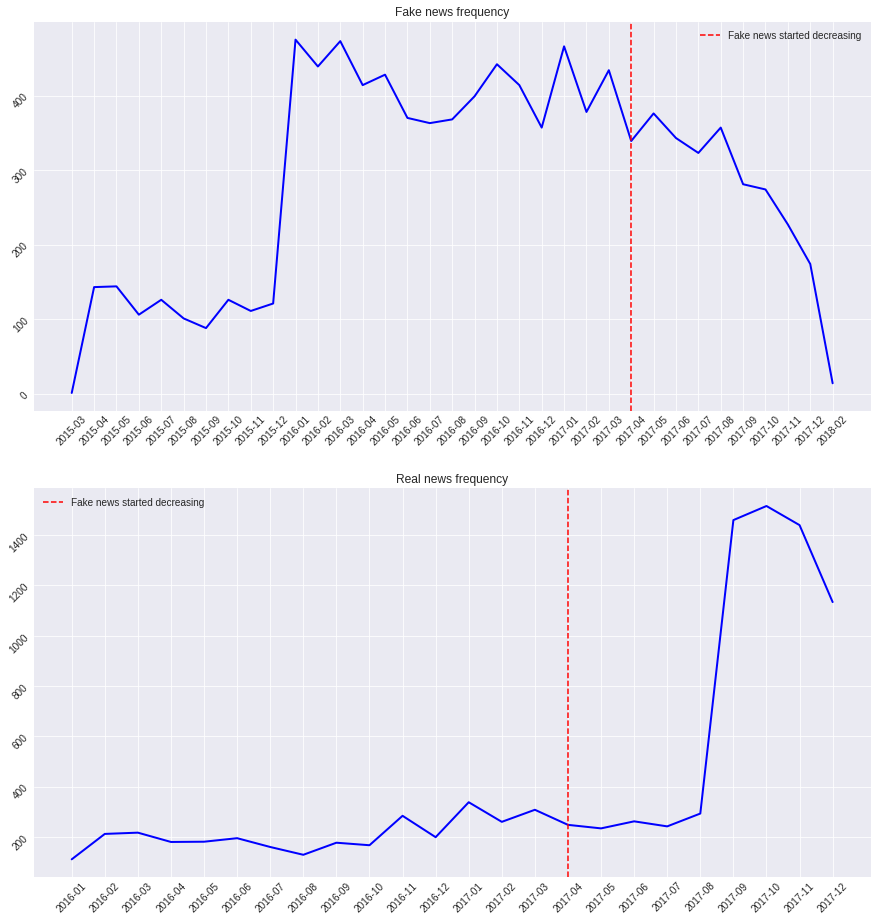

In [86]:
def split_date_to_month(date):
    d = datetime.datetime.strptime(date, format_)
    month = str(d.month).zfill(2)
    year  = str(d.year)
    
    return year + "-" + month

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
df['month'] = df['date'].apply(lambda x : split_date_to_month(x))
fake_count = df[df['label'] == 0].groupby('month').count()
real_count = df[df['label'] == 1].groupby('month').count()

ax[0].plot(fake_count['label'], color='blue', linewidth=2)
ax[0].tick_params(rotation=45)
ax[0].axvline(25, color='red', label='Fake news started decreasing', linestyle="--")
ax[0].set_title("Fake news frequency")
ax[0].legend()

ax[1].plot(real_count['label'], color='blue', linewidth=2)
ax[1].tick_params(rotation=45)
ax[1].axvline(15, color='red', label='Fake news started decreasing', linestyle="--")
ax[1].set_title("Real news frequency")
ax[1].legend()

plt.subplots_adjust(top=2.5)
plt.show()

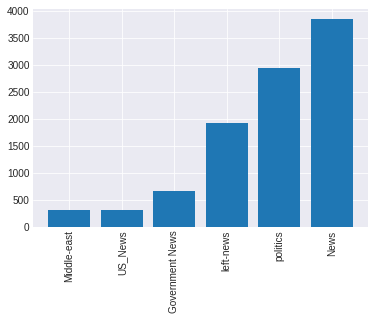

In [87]:
fake = df[df['label'] == 0]
fake_by_subjects = fake.groupby('subject').count()['label']

freq = fake_by_subjects.values

# Sort both subjects and frequency values by values
freq = fake_by_subjects.values[np.argsort(fake_by_subjects.values)]
subjects = fake_by_subjects.index[np.argsort(fake_by_subjects.values)]

plt.bar(subjects, freq)
plt.xticks(rotation=90)
plt.show()

# III. Text data cleaning and exploration 

## 1. Expanding contraction

In [88]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

print("[INFO] Expanding contraction ... ")
df['title'] = df['title'].apply(lambda x : expand_contractions(x))
df['text'] = df['text'].apply(lambda x : expand_contractions(x))
print("[INFO] Done!")

[INFO] Expanding contraction ... 
[INFO] Done!


## 2. Lowercasing text

In [89]:
print('[INFO] Lowercasing text ... ')
df['title'] = df['title'].apply(lambda x : x.lower())
df['text'] = df['text'].apply(lambda x : x.lower())
print('[INFO] Done!')

[INFO] Lowercasing text ... 
[INFO] Done!


## 3. Removing digits

In [90]:
print('[INFO] Removing digits ... ')
df['title']=df['title'].apply(lambda x: re.sub('\w*\d\w*','', x))
df['text']=df['text'].apply(lambda x: re.sub('\w*\d\w*','', x))
print('[INFO] Done!')

[INFO] Removing digits ... 
[INFO] Done!


## 4. Removing punctuations

In [91]:
print('[INFO] Removing punctuations ... ')
df['title']=df['title'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['text']=df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
print('[INFO] Done!')

[INFO] Removing punctuations ... 
[INFO] Done!


In [92]:
print('[INFO] Removing extra spaces ...')
df['title']=df['title'].apply(lambda x: re.sub(' +',' ',x))
df['text']=df['text'].apply(lambda x: re.sub(' +',' ',x))
print('[INFO] Done!')

[INFO] Removing extra spaces ...
[INFO] Done!


## 5. Stopwords removal and lemmatization

In [93]:
### Stopword removal using the nltk way ###
!python3 -m nltk.downloader stopwords punkt wordnet
stop_words = set(stopwords.words('english')) # Assuming all nltk data is installed
lemmatizer = WordNetLemmatizer()

def filter_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]
    filtered_sentence = ' '.join(filtered)

    ### Removing all special characters ###
    special_chars = ['…', '–', '’', '‘', '”', '“']

    for char_ in special_chars:
      filtered_sentence = filtered_sentence.replace(char_, "")

    # Removal of extra spaces
    filtered_sentence = re.sub(' +',' ',filtered_sentence)
    return filtered_sentence

print('[INFO] Removing stop words and lemmatizing ... ')
df['title'] = df['title'].apply(lambda x : filter_stopwords(x))
df['text'] = df['text'].apply(lambda x : filter_stopwords(x))
print('[INFO] Done!')


/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[INFO] Removing stop words and lemmatizing ... 
[INFO] Done!


# IV. Text data vectorization

In [94]:
features_text = df['text'].values
labels = df['label'].values
vfunc = np.vectorize(lambda x : len(x.split(' ')))
all = ' '.join(features_text)
vocab_size = len(list(set(all.split(" ")))) + 1
max_seq_len = min(vfunc(features_text).max(), 256)
max_vocab = 10000

tokenizer = Tokenizer(num_words=max_vocab, char_level=False, oov_token='<PAD>')
tokenizer.fit_on_texts(all.split(" "))

features = tokenizer.texts_to_sequences(features_text)
features = pad_sequences(features, maxlen=max_seq_len)
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.333333)

print(f'[INFO] Max sequence length : {max_seq_len}')
print(f'[INFO] Vocabulary size : {vocab_size}')

[INFO] Max sequence length : 256
[INFO] Vocabulary size : 125195


# V. Constructing models

## 1. CNN

In [106]:
### Training ###
def make_cnn_model(vocab_size, num_classes, seq_len):
  inputs = Input(shape=(seq_len,))
  embs = Embedding(vocab_size, 128, trainable=False)(inputs)

  conv1 = Conv1D(32, kernel_size=4, padding='same', activation='relu')(embs)
  pool1 = MaxPool1D(pool_size=2)(conv1)
  #conv2 = Conv1D(64, kernel_size=3, padding='same', activation='relu')(pool1)
  #pool2 = MaxPool1D(pool_size=2)(conv2)

  #rnn1 = LSTM(64, return_sequences=True, recurrent_dropout = 0.25 , dropout = 0.25)(pool1)
  #rnn2 = LSTM(32, return_sequences=False, recurrent_dropout = 0.1 , dropout = 0.1)(rnn1)
  output = Flatten()(pool1)
  output = Dense(num_classes, activation='softmax')(output)

  model = Model(inputs=inputs, outputs=output, name='CNN_SentimentAnalysis')
  return model

model = make_cnn_model(vocab_size, 2, max_seq_len)
print(model.summary())

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Model: "CNN_SentimentAnalysis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 256, 128)          16024960  
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 256, 32)           16416     
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 128, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 8194      
Total params: 16,049,570
Trainable params: 16,049,570
Non-trainable params: 0
_________________________________

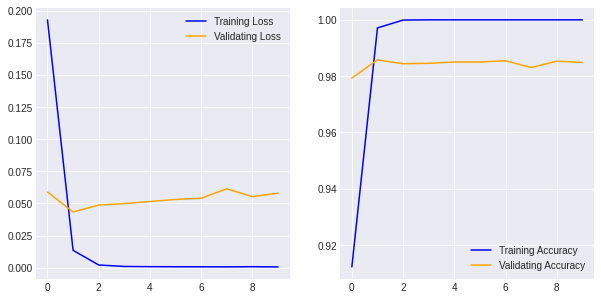

In [107]:
### Visualization ###
loss, val_loss = history.history['loss'], history.history['val_loss']
accuracy, val_accuracy = history.history['accuracy'], history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(loss, color='blue', label='Training Loss')
ax[0].plot(val_loss, color='orange', label='Validating Loss')
ax[1].plot(accuracy, color='blue', label='Training Accuracy')
ax[1].plot(val_accuracy, color='orange', label='Validating Accuracy')

ax[0].legend()
ax[1].legend()
plt.show()

## 2. Bidirectional RNN (LSTM)

In [108]:
def make_birnn_model(vocab_size, emb_size, seq_len, embedding_matrix): 
  model = Sequential()
  #Non-trainable embeddidng layer
  model.add(Embedding(vocab_size, output_dim=emb_size, weights=[embedding_matrix], input_length=seq_len, trainable=False))
  #LSTM 
  model.add(Bidirectional(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25)))
  model.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1)))
  model.add(Dense(units = 32 , activation = 'relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

  return model

emb_mean = 0.0
emb_std = 1.0
emb_size = 64
embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, emb_size))
model = make_birnn_model(vocab_size, emb_size, max_seq_len, embedding_matrix)
print(model.summary())

history = model.fit(x_train, y_train, batch_size=256, epochs=10, validation_data=(x_val, y_val))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 256, 64)           8012480   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256, 256)          197632    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_40 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 33        
Total params: 8,378,625
Trainable params: 366,145
Non-trainable params: 8,012,480
_________________________________________________________________
None
Epoch 1/10
52/52 [==============================] - 192s 4s/step - loss: 0.4782 - accuracy: 0.7632 

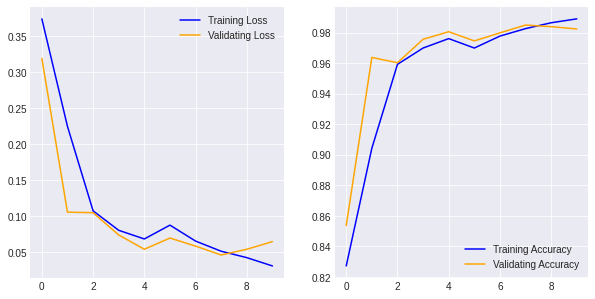

In [109]:
### Visualization ###
loss, val_loss = history.history['loss'], history.history['val_loss']
accuracy, val_accuracy = history.history['accuracy'], history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(loss, color='blue', label='Training Loss')
ax[0].plot(val_loss, color='orange', label='Validating Loss')
ax[1].plot(accuracy, color='blue', label='Training Accuracy')
ax[1].plot(val_accuracy, color='orange', label='Validating Accuracy')

ax[0].legend()
ax[1].legend()
plt.show()